In [1]:
import pandas as pd
import numpy as np
import vertica_python
import os
import seaborn as sns
import scipy

In [246]:
sns.set_context("poster", font_scale=3, rc={"lines.linewidth": 5})

In [3]:
%matplotlib inline

In [4]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [196]:
course_length_query = """

SELECT
a.user_id,
a.course_id,
DATEDIFF('day', c.course_start_date, c.course_end_date) AS days_course_start_to_end,
DATEDIFF('day', b.content_availability_date, a.passed_timestamp) AS days_to_pass
FROM business_intelligence.course_completion_user a 
join business_intelligence.user_content_availability_date b
ON a.user_id = b.user_id
AND a.course_id = b.course_id
AND b.enroll_group = 'enroll_before_course_start'
AND passed_timestamp IS NOT NULL
JOIN business_intelligence.course_master c
ON a.course_id = c.course_id
AND c.pacing_type = 'instructor_paced'
WHERE DATEDIFF('day', b.content_availability_date, a.passed_timestamp) > 6
"""

In [138]:
course_completion_rate_query = """

select
CASE 
WHEN a.current_enrollment_mode = 'verified' THEN 'verified'
ELSE 'audit'
END AS current_enrollment_mode,
a.course_id,
c.course_subject,
c.course_partner,
c.course_name,
c.course_seat_price,
c.content_language,
c.level_type,
c.is_wl,
COUNT(1) AS cnt_enrolls,
COUNT(passed_timestamp) AS cnt_passed,
COUNT(passed_timestamp) * 100.0/COUNT(1) AS completion_rate
from business_intelligence.user_content_availability_date a
join business_intelligence.course_completion_user b
on a.user_id = b.user_id
and a.course_id = b.course_id
join business_intelligence.course_master c
ON a.course_id = c.course_id
AND c.pacing_type = 'instructor_paced'
AND a.enroll_group = 'enroll_before_course_start'
AND a.current_enrollment_mode IN ('honor','audit','verified')
AND a.content_availability_date BETWEEN '2016-07-01' AND '2017-06-30'
GROUP BY 1,2,3,4,5,6,7,8,9


"""

In [197]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(course_length_query)
extract = cur.fetchall()
course_length_df = pd.DataFrame(extract)

connection.close()

In [139]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(course_completion_rate_query)
extract = cur.fetchall()
course_completion_rate_df = pd.DataFrame(extract)

connection.close()

In [198]:
course_length_df.head()

,user_id,course_id,days_course_start_to_end,days_to_pass
0,6869,WellesleyX/HIST229x/2013_SOND,108.0,101
1,8149,WellesleyX/HIST229x/2013_SOND,108.0,102
2,16326,WellesleyX/HIST229x/2013_SOND,108.0,99
3,16953,WellesleyX/HIST229x/2013_SOND,108.0,99
4,23712,WellesleyX/HIST229x/2013_SOND,108.0,98


In [199]:
course_length_df['days_to_pass'] = df['days_to_pass'].astype(int)

In [206]:
course_length_agg_df = course_length_df.groupby('course_id').mean()['days_to_pass'].reset_index()
course_length_agg_df['median_time_to_pass'] = course_length_df.groupby('course_id').quantile(0.5)['days_to_pass'].values
course_length_agg_df['course_start_to_end_days'] = course_length_df.groupby('course_id').mean()['days_course_start_to_end'].values
course_length_agg_df = course_length_agg_df.rename(index=str, columns={"days_to_pass": "mean_time_to_pass"})

In [207]:
course_length_agg_df.head()

,course_id,mean_time_to_pass,median_time_to_pass,course_start_to_end_days
0,AdelaideX/HumBio101x/1T2015,32.578671,33.0,42.0
1,BUx/ARPO222x/3T2014,58.494774,54.0,56.0
2,BUx/ASTR105x/3T2014,53.556098,51.0,66.0
3,BUx/INTL301x/3T2014,46.670433,37.0,43.0
4,BUx/Math226.1x/1T2015,52.554000,51.0,63.0


In [143]:
course_completion_rate_df.head()

,current_enrollment_mode,course_id,course_subject,course_partner,course_name,course_seat_price,content_language,level_type,is_wl,cnt_enrolls,cnt_passed,completion_rate
0,audit,course-v1:RWTHx+EBWL101+3T2016,None,RWTHx,Einführung in die Betriebswirtschaftslehre,49.0,de-de,Introductory,0,5,1,20.0000000000000000000
1,audit,course-v1:ACCA+FA2-MA2.X+3T2016,None,ACCA,Intermediate Financial and Management Accounting,NaN,en-us,Introductory,0,478,264,55.2301255230125523013
2,audit,course-v1:BerkleeX+OHARM-100x+1T2017,Humanities,BerkleeX,Introduction to Music Theory,49.0,en-us,Introductory,0,990,82,8.2828282828282828283
3,verified,course-v1:KironX+FHLCNx+2T2017,Communication,KironX,Computer Networks and the Internet,79.0,en-us,Introductory,0,3,0,0E-19
4,verified,course-v1:UAMx+SegAlim201x+3T2016,Food & Nutrition,UAMx,De la granja a la mesa: La seguridad alimentar...,50.0,es-es,Introductory,0,16,15,93.7500000000000000000


In [209]:
df_master = course_completion_rate_df.merge(course_length_agg_df, on = 'course_id')

In [210]:
df_master['completion_rate'] = df_master['completion_rate'].astype('float64')

In [211]:
course_completion_rate_df.shape

(1328, 12)

In [212]:
course_length_agg_df.shape

(1768, 4)

In [213]:
df_master.shape

(1271, 15)

In [221]:
df_master_filtered = df_master[df_master['cnt_enrolls']>100]

In [222]:
pd.cut(df_master_filtered.median_time_to_pass,
       bins = [0, 30, 45, 60, 90, 180]
      ).reset_index().groupby('median_time_to_pass').count()

,index
median_time_to_pass,
"(0, 30]",129
"(30, 45]",256
"(45, 60]",152
"(60, 90]",106
"(90, 180]",19


In [223]:
pd.cut(df_master_filtered.course_start_to_end_days,
       bins = [0, 30, 45, 60, 90, 180]
      ).reset_index().groupby('course_start_to_end_days').count()

,index
course_start_to_end_days,
"(0, 30]",37
"(30, 45]",145
"(45, 60]",190
"(60, 90]",206
"(90, 180]",70


In [248]:
df_master_filtered['median_time_to_pass_bins'] = pd.cut(df_master_filtered.median_time_to_pass,
       bins = [0, 30, 45, 60, 90, 180])

df_master_filtered['course_start_to_end_days_bins'] = pd.cut(df_master_filtered.course_start_to_end_days,
       bins = [0, 30, 45, 60, 90, 180],
        labels = ['0-30d','30-45d', '45-60d','60-90d', '>90d'])

/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [225]:
def top_n_list(df, group, n):
    
    return df.groupby(group).count()['course_id'].sort_values(ascending = False).index[:n]

In [232]:
# subject_list = top_n_list(df_master_filtered, 'course_subject', 5)

# temp_df = df_master_filtered[df_master_filtered.course_subject.isin(subject_list)]

# sns.factorplot(
#     data = temp_df[temp_df.current_enrollment_mode=='audit'],
#     x = 'median_time_to_pass_bins',
#     y = 'completion_rate',
#     row = 'current_enrollment_mode',
#     size = 10, 
#     aspect = 2,
#     kind = 'point',
#     #hue = 'level_type'


# )

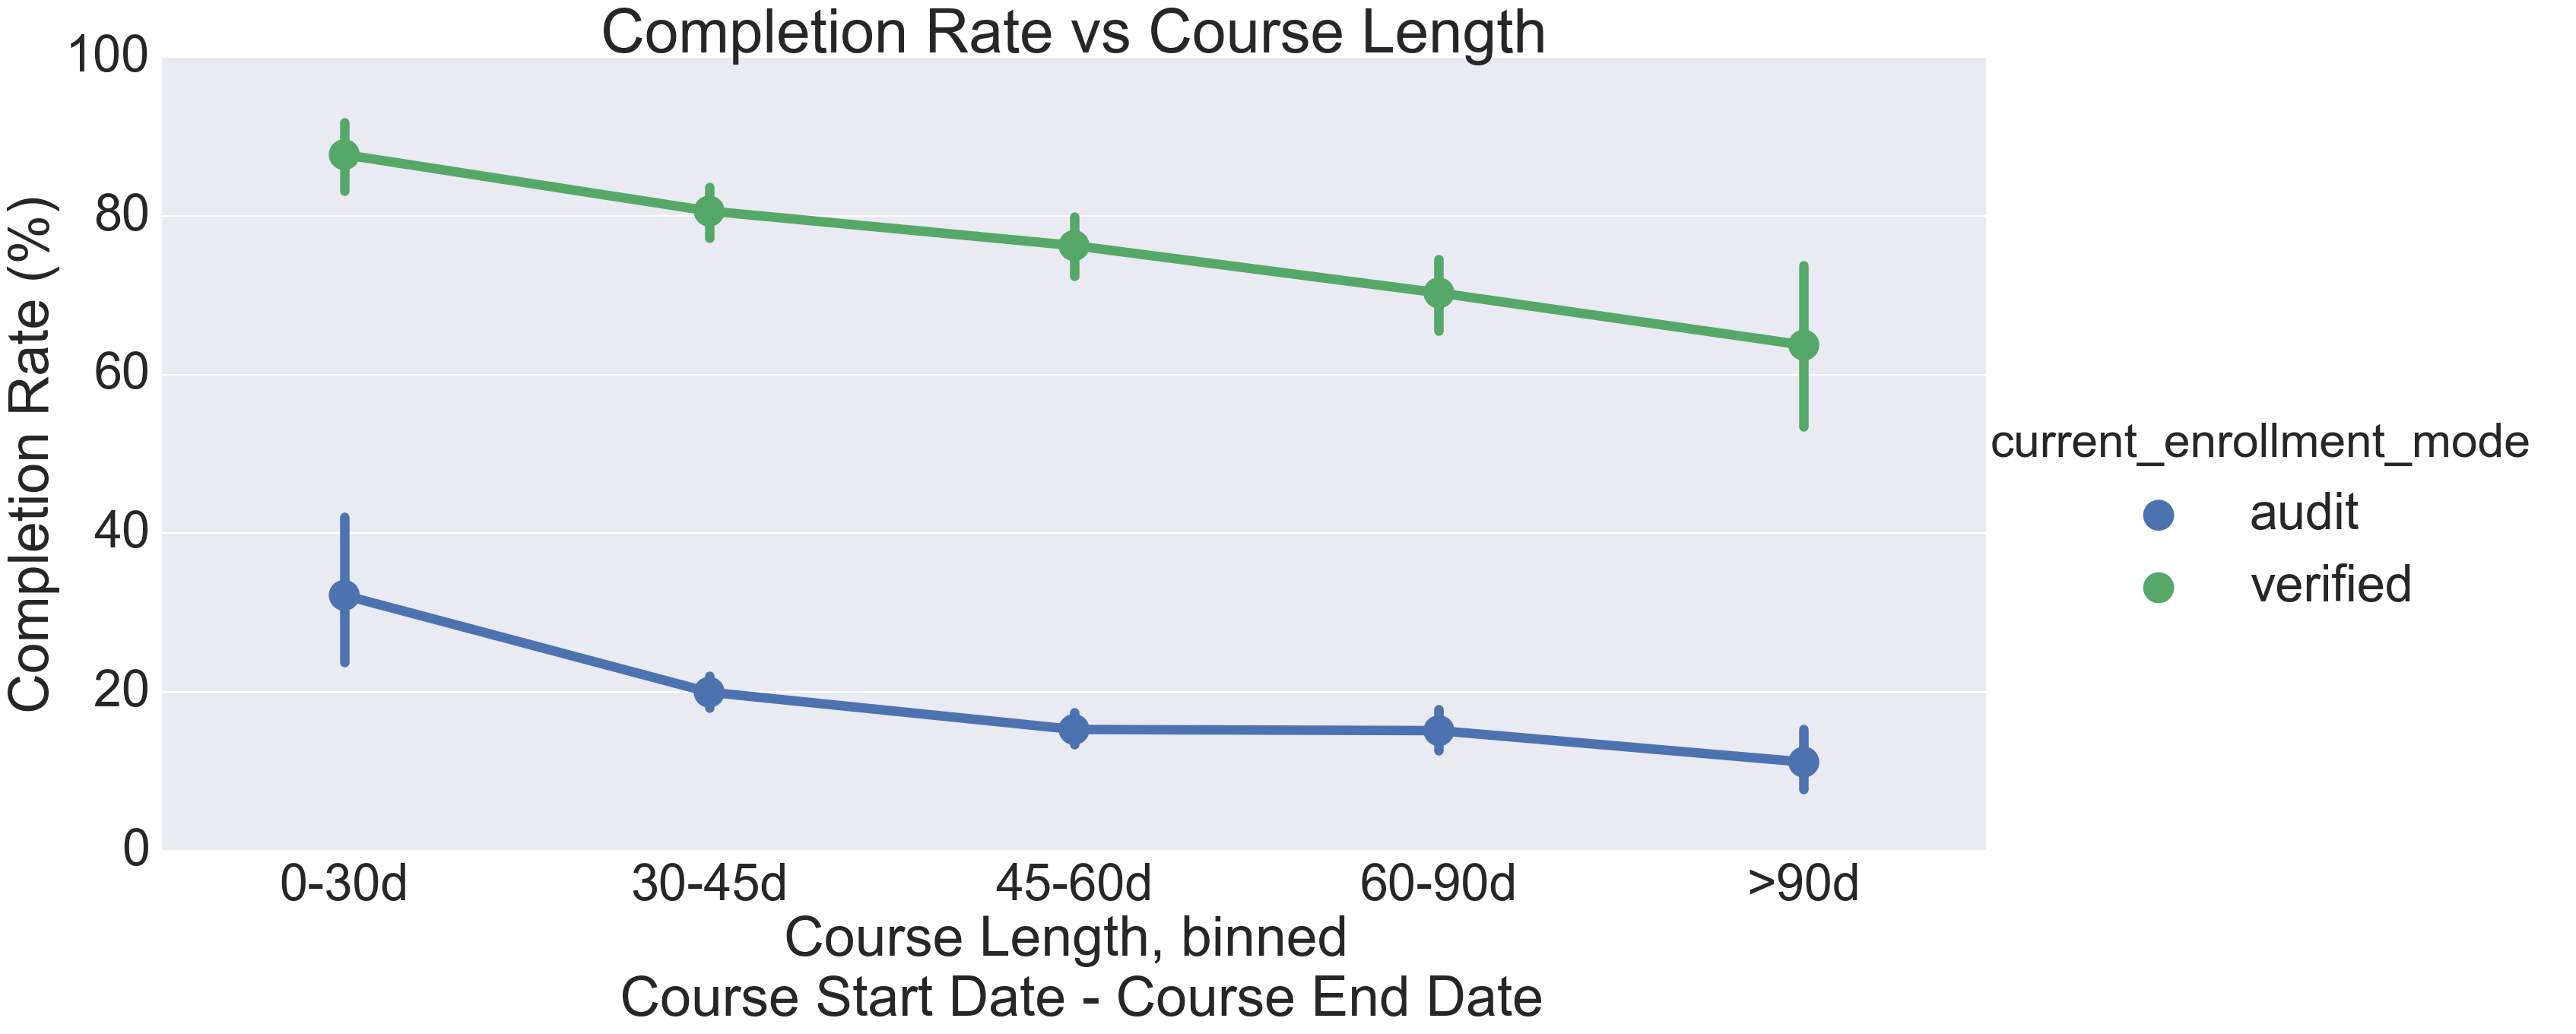

In [250]:
ax = sns.factorplot(
    data = df_master_filtered,
    x = 'course_start_to_end_days_bins',
    y = 'completion_rate',
    size = 14, 
    aspect = 2,
    kind = 'point',
    hue = 'current_enrollment_mode'
)

ax.set(
    title = 'Completion Rate vs Course Length',
    xlabel = 'Course Length, binned \n (Course Start Date - Course End Date)',
    ylabel = 'Completion Rate (%)'


)

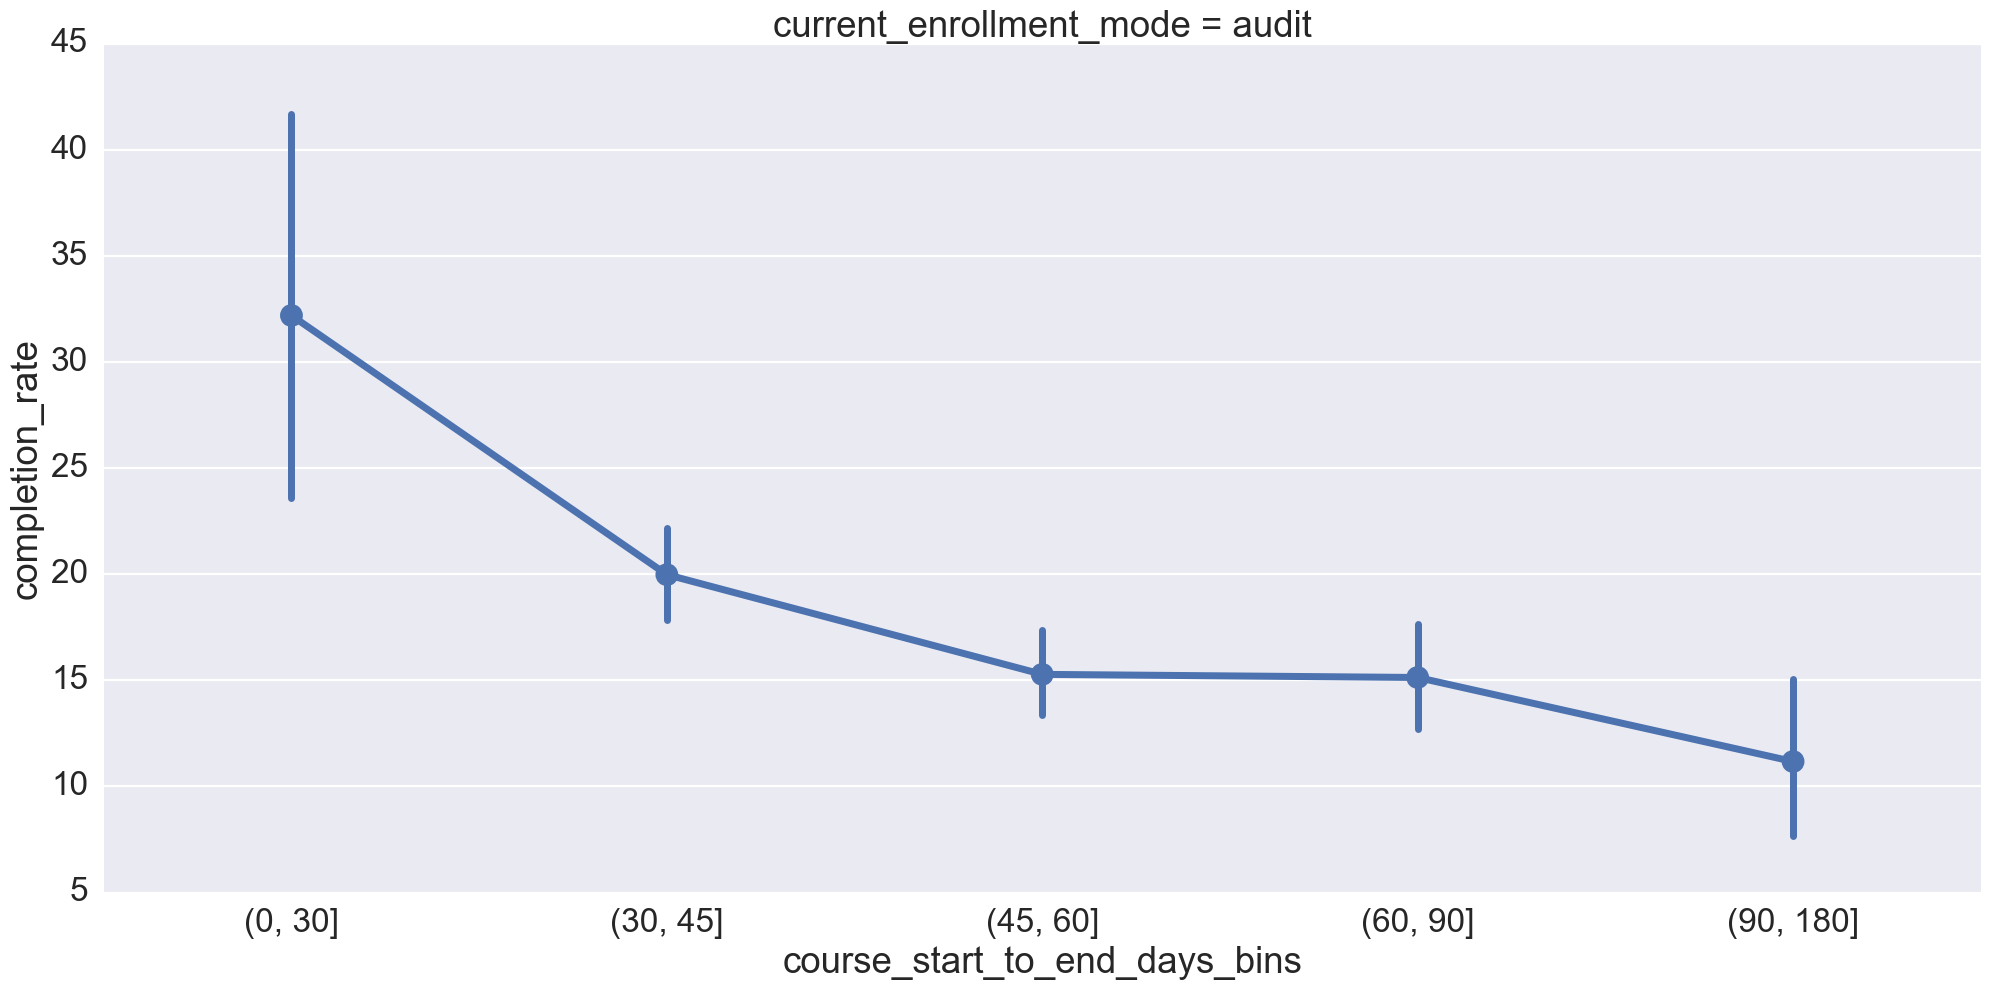

In [236]:
temp_df = df_master_filtered

sns.factorplot(
    data = temp_df[temp_df.current_enrollment_mode=='audit'],
    x = 'course_start_to_end_days_bins',
    y = 'completion_rate',
    row = 'current_enrollment_mode',
    size = 10, 
    aspect = 2,
    kind = 'point',
    #hue = 'level_type'


)

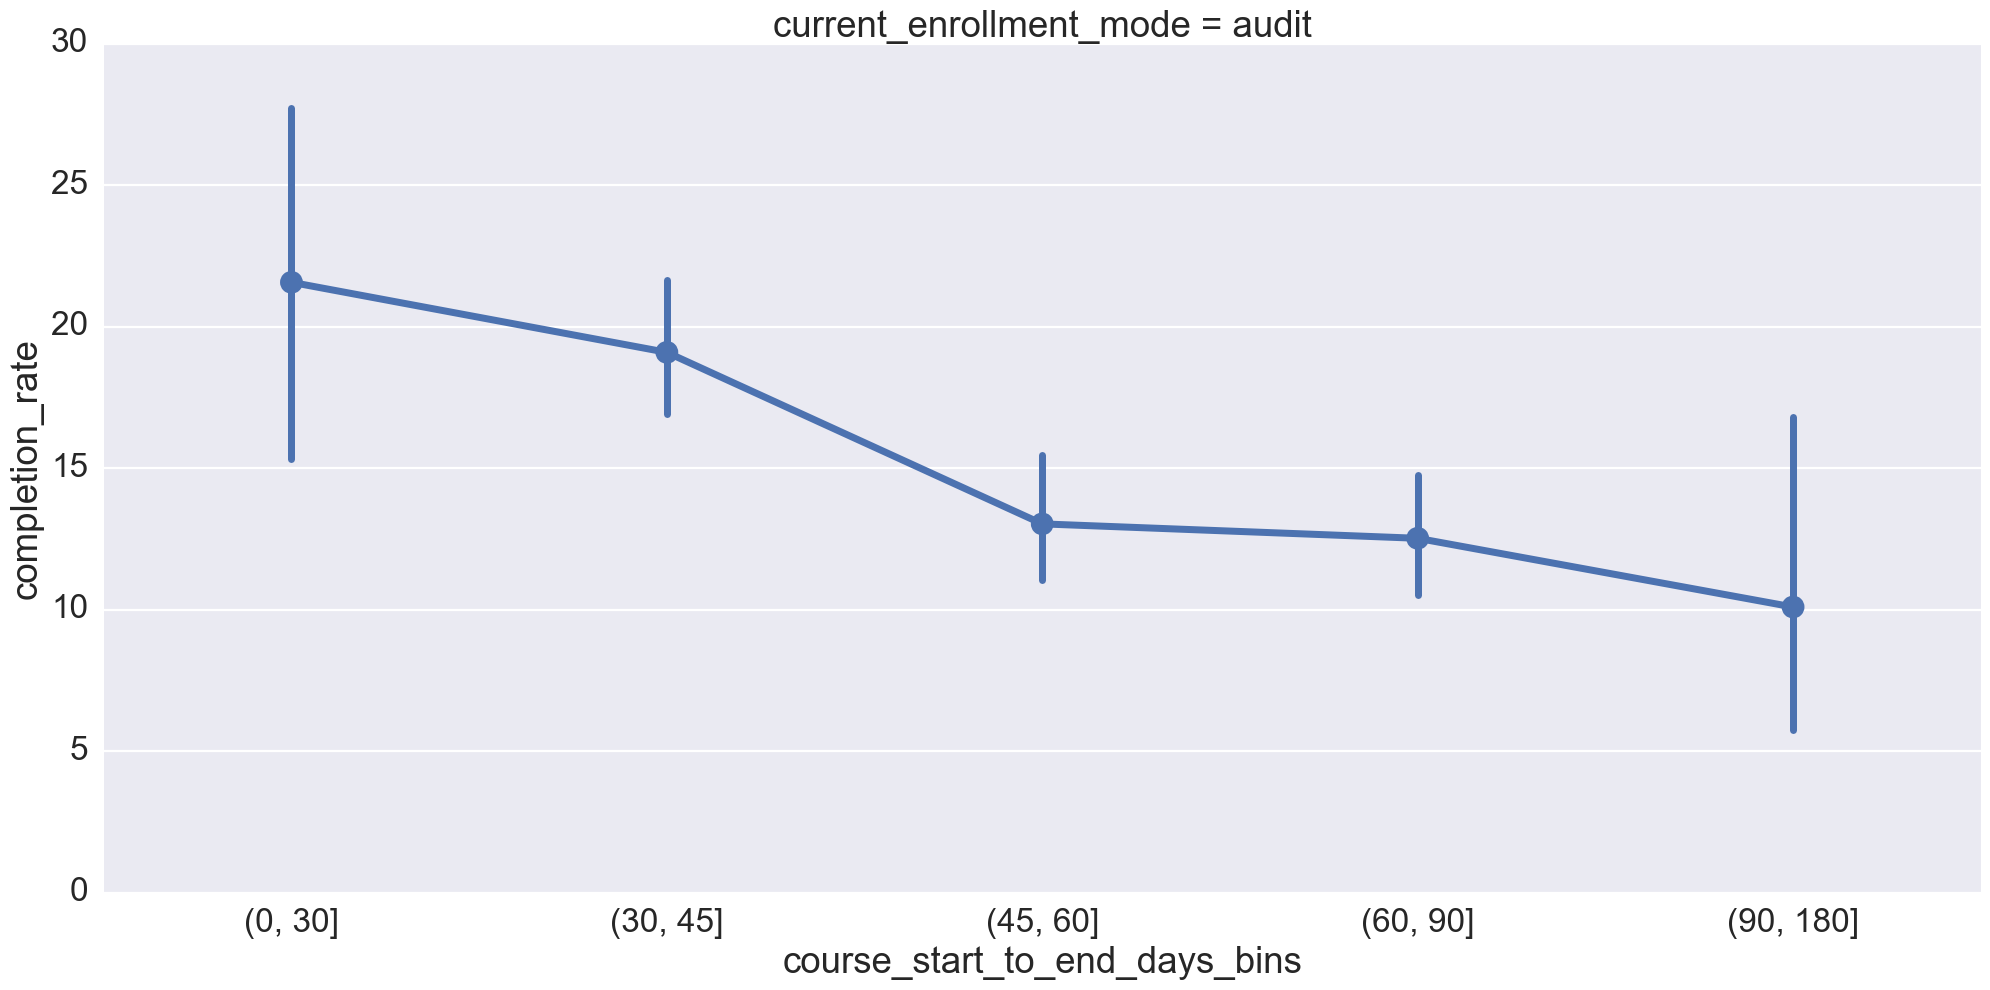

In [231]:
subject_list = top_n_list(df_master_filtered, 'course_subject', 5)

temp_df = df_master_filtered[df_master_filtered.course_subject.isin(subject_list)]

sns.factorplot(
    data = temp_df[temp_df.current_enrollment_mode=='audit'],
    x = 'course_start_to_end_days_bins',
    y = 'completion_rate',
    row = 'current_enrollment_mode',
    size = 10, 
    aspect = 2,
    kind = 'point',
    #hue = 'level_type'


)

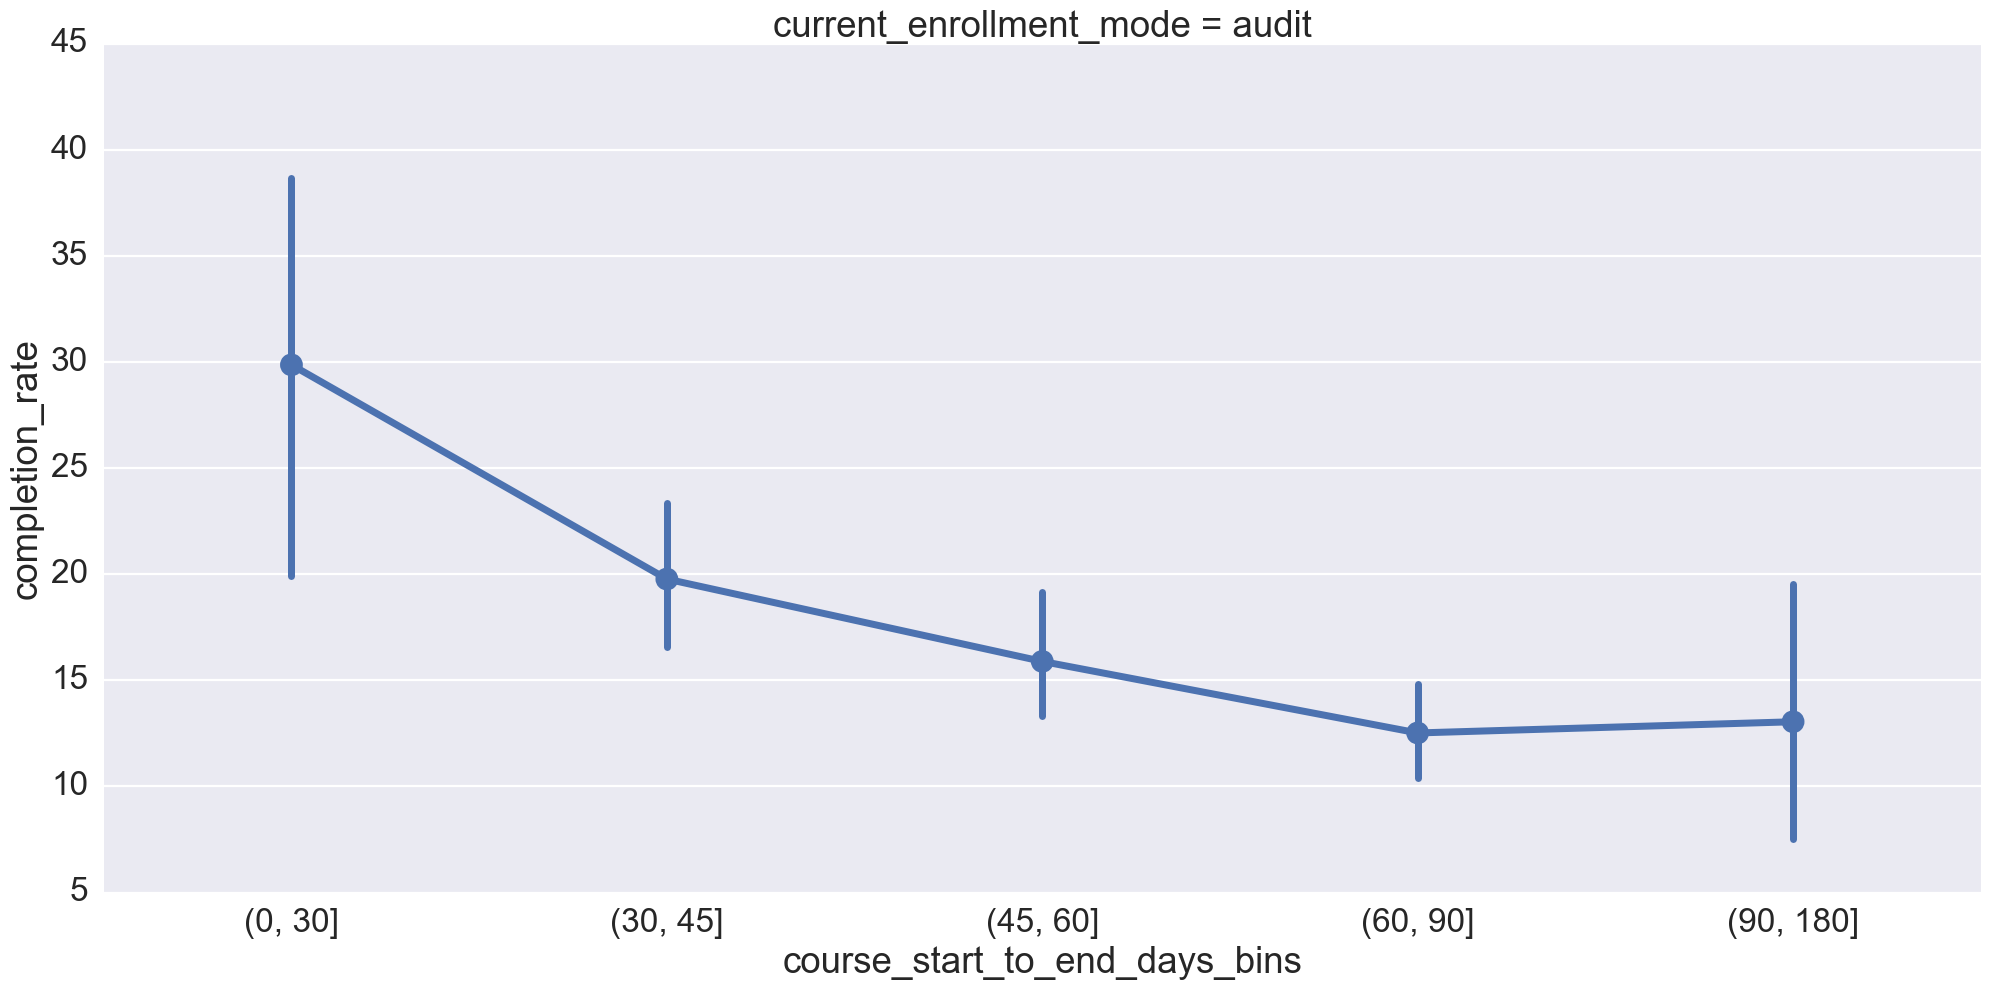

In [233]:
partner_list = top_n_list(df_master_filtered, 'course_partner', 10)

temp_df = df_master_filtered[df_master_filtered.course_partner.isin(partner_list)]

sns.factorplot(
    data = temp_df[temp_df.current_enrollment_mode=='audit'],
    x = 'course_start_to_end_days_bins',
    y = 'completion_rate',
    row = 'current_enrollment_mode',
    size = 10, 
    aspect = 2,
    kind = 'point',
    #hue = 'is_wl'


)